# Stitch COCO-Periph Images to Create Pseudofoveated

In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def readin_imglist(imgnum, eccs = [0,5,10,15,20],filepath='./COCO_Periph'):
    '''
    Readin the uniform images at each of the eccentricities according to our filestructure

    Parameters:
        imgnum (str): the MS COCO Image number desired
        eccs (list of floats): the eccentricities in degrees desired
        filepath (str): path to the COCO Periph Directory
    Returns:
        imglist (list of numpy arrays): List of uniformly foveated images
    '''
    imglist = []
    for e in eccs:
        if(e==0):
            #impath = os.path.join(filepath,f'{imgnum.zfill(12)}.jpg') #demo img
            impath = os.path.join(filepath,f'ecc_0',f'{imgnum.zfill(12)}.jpg') #ccp_search18_train_subset
        else:
            #impath = os.path.join(filepath,f'mongrel_{imgnum.zfill(12)}_ecc_{e*16}_0.jpg') #demo img
            impath = os.path.join(filepath,f'ecc_{e}',f'{imgnum.zfill(12)}.jpg') #ccp_search18_train_subset

        print(impath)
        im = cv2.cvtColor(cv2.imread(impath), cv2.COLOR_BGR2RGB)
        imglist.append(im)
    return(imglist)

#uniform_imgs = readin_imglist('11197',filepath='./demo_img/')
uniform_imgs = readin_imglist('552305',filepath='./ccp_search18_train_subset/')

./ccp_search18_train_subset/ecc_0/000000552305.jpg
./ccp_search18_train_subset/ecc_5/000000552305.jpg
./ccp_search18_train_subset/ecc_10/000000552305.jpg
./ccp_search18_train_subset/ecc_15/000000552305.jpg
./ccp_search18_train_subset/ecc_20/000000552305.jpg


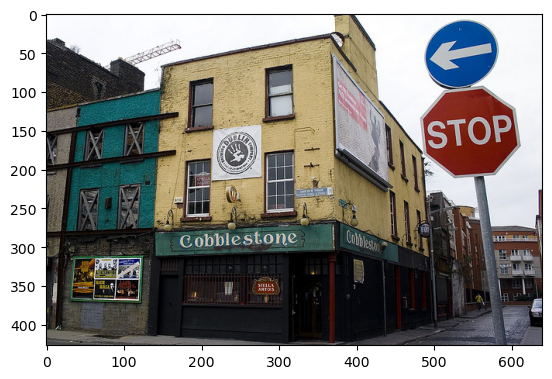

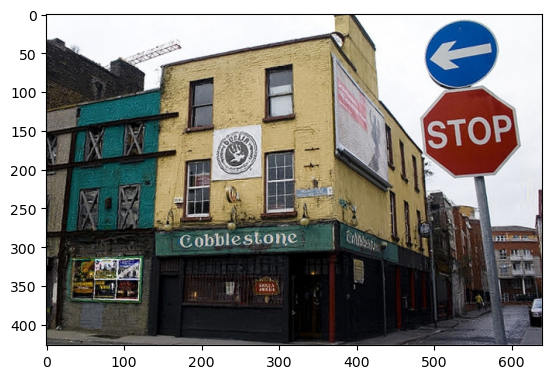

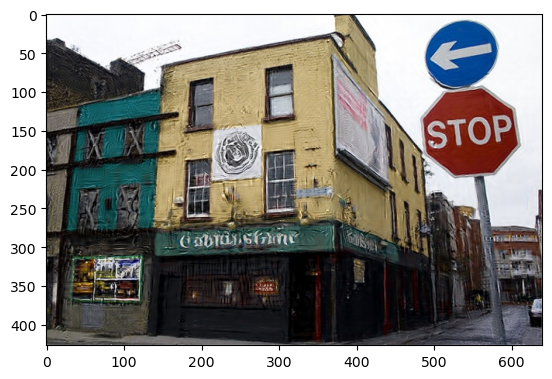

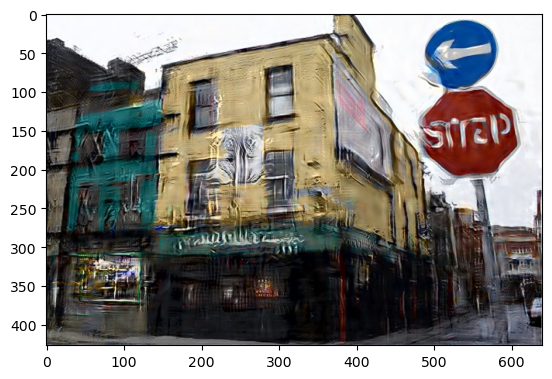

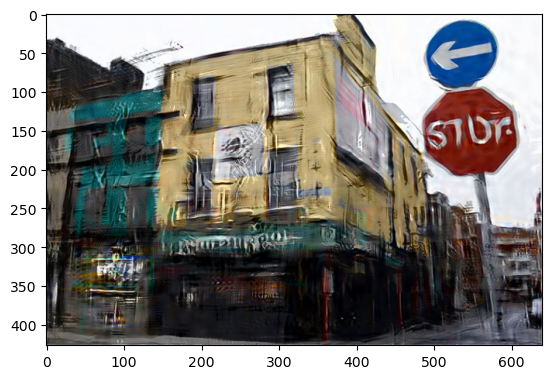

In [3]:
for im in uniform_imgs:
    plt.imshow(im)
    plt.show()

0 [0, 16]


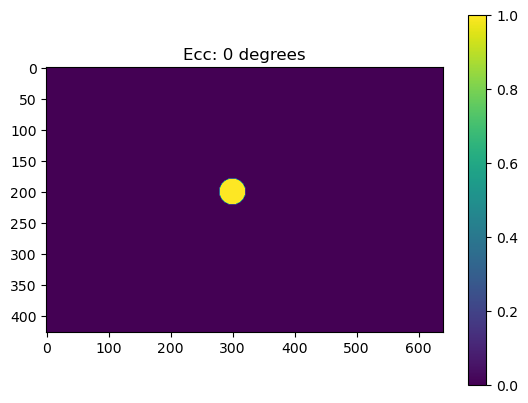

5 [16, 120]


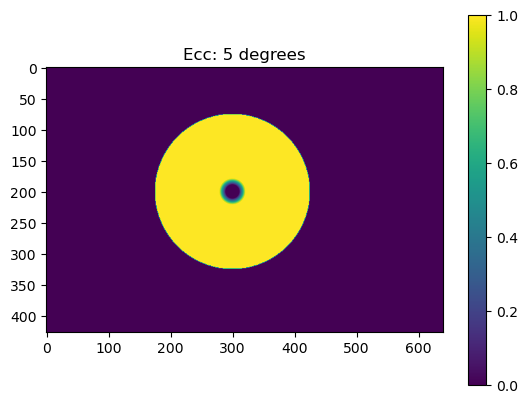

40 40
10 [120, 200]


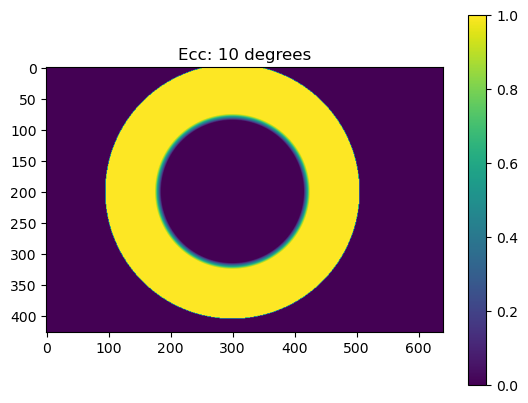

40 40
15 [200, 280]


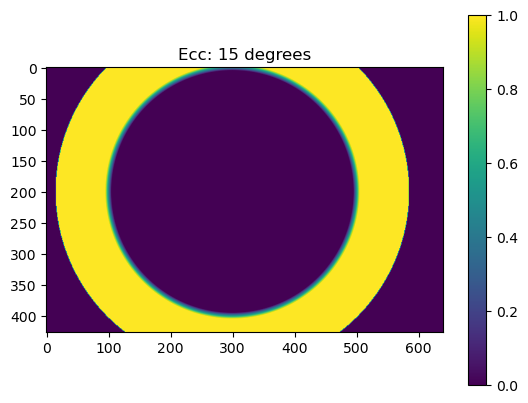

20 [280, 1e+100]


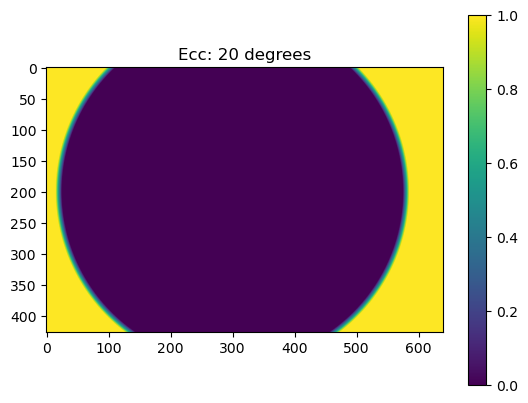

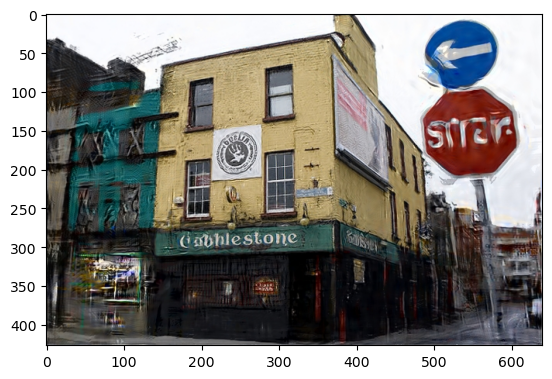

In [4]:
def stitch_image(uniform_imlist, fixation, deglist=[0,5,10,15,20], ppd=16, blend_radius = 5):
    '''
    Funtion to stitch together uniformly tiled coco-periph images to create a new
    transformed peripheral image representing progressive loss of information from
    the chosen fixation location

    Parameters:
        uniform_imlist (list of numpy arrays): list of uniform foveated images to be stitched, starting from 0 degrees to furthest
            *Note*: All images in imlist must be the same size, and should start with an original image, then uniform transforms.
        fixation (tuple): (x,y) fixation location specified in pixels (dist from left, dist from top)
        deglist (list of floats or ints): list of eccentricities represented by each image in imlist.
            *Note*: imlist and deglist must be the same length, and start with zero and increase.
        ppd (int): how many pixels subtend 1 degree viewing angle? (This is calculated by viewing distance, and COCO-Periph uses 16ppd)
            *Note*: PPD also specifies the fovea size, or the radius of the original image in the center of fixation.
            *Note2*: Leave this at 16 if you are using COCO-Periph Images.
        blend_radius (int): How many pixels on each side of the stitching border between images do we blend with? This avoids circular borders.    

    Returns:
        pseudo_im (numpy array): Pseudofoveated Image
    
    '''
    #assume a 1 degree radius fovea
    fovea_size = ppd
    #convert degree list to pixel radius from center
    pixel_list = [ppd * d for d in deglist]
    #print(pixel_list)

    #calcualte indices for each pixel
    fx_x, fx_y = fixation
    #print(np.shape(uniform_imlist[0]))
    img_shape_y, img_shape_x, _ = np.shape(uniform_imlist[0])
    y, x = np.indices([img_shape_y, img_shape_x])
    #print(y)
    #print(x)

    #fill whole image with furthest eccentricity
    pseudo_im = uniform_imlist[-1]
    #loop through closer eccentricities and fill in donuts around the center
    for i, ecc in enumerate(deglist):
        #if this is fovea, should be a circle at the center of fixation.
        if(i==0):
            ecc_range = [0,fovea_size]
        #otherwise create rings around center
        else:
            #first image is a special case, start out from fovea, then go out to halfway between first and second boundary
            if(i==1):
                #offset puts the border halfway between limit of this eccentricity and next eccentricity up.
                ecc_offset_above = (pixel_list[2] - pixel_list[1])//2
                ecc_range = [fovea_size,pixel_list[i]+ecc_offset_above]
            #last image is also a special case because we have no border above.
            elif(i==len(deglist)-1):
                # We've seeded the pseudo_im with this image already, so don't need to do this, but do it for completeness.
                ecc_offset_below = (pixel_list[i] - pixel_list[i-1])//2 #this is the offset_above from the last loop
                #our range in pixels for this eccentricity is centered at this pixel eccentricity, and halfway above and below to the neighboring ecc. 
                ecc_range = [pixel_list[i]-ecc_offset_below,1e100]
            #all others blend bidirectionally.
            else:
                #here we need the offset both above and below
                ecc_offset_above = (pixel_list[i+1] - pixel_list[i])//2
                ecc_offset_below = (pixel_list[i] - pixel_list[i-1])//2 #this is the offset_above from the last loop
                #our range in pixels for this eccentricity is centered at this pixel eccentricity, and halfway above and below to the neighboring ecc. 
                ecc_range = [pixel_list[i]-ecc_offset_below,pixel_list[i]+ecc_offset_above]
                print(ecc_offset_below, ecc_offset_above)
        print(ecc, ecc_range)
        
        #Now that we've specified the range, create a mask for a ring/doughnut at this eccentricity (plus the blending region)
        normalized = ((x-fx_x),(y-fx_y)) #distance from fixation
        r = np.hypot(normalized[0], normalized[1])
        ecc_mask = np.where((r>=ecc_range[0]) & (r<ecc_range[1]+blend_radius),1., 0.).astype(np.float32)
        #print(ecc_mask.shape)
        # plt.pcolormesh(ecc_mask)
        # plt.show()
        
        #gaussian blending to remove sharp edges
        if(i>0):
            start_blend_r = ecc_range[0]-blend_radius
            end_blend_r = ecc_range[0]+blend_radius
            #mask must extend lower for linear blend
            ecc_mask = np.where((r>=start_blend_r) & (r<ecc_range[1]+blend_radius),1.,0.).astype(np.float32)
            ecc_mask = np.where((r>=start_blend_r) & (r<end_blend_r),(r-start_blend_r)/(end_blend_r-start_blend_r),ecc_mask)
        
        #create masks
        ecc_mask_3d = np.concatenate((ecc_mask[:,:,None],ecc_mask[:,:,None],ecc_mask[:,:,None]),2)
        invert_mask = 1.0-ecc_mask_3d
        
        #optional plotting of masks
        plt.imshow(ecc_mask_3d[:,:,0])
        plt.colorbar()
        plt.title(f'Ecc: {ecc} degrees')
        plt.savefig(f'./mask_ecc_{ecc}.png')
        
        plt.show()
        # plt.imshow(invert_mask[:,:,0])
        # plt.colorbar()
        # plt.show()

        pseudo_im = np.uint8(ecc_mask_3d * uniform_imlist[i] + invert_mask * pseudo_im)

    return(pseudo_im)

stitched_image = stitch_image(uniform_imgs, (300,200))
plt.imshow(stitched_image)

#write stitched image to file
#stitched_image_cv2 = cv2.cvtColor(stitched_image, cv2.COLOR_RGB2BGR) 
#cv2.imwrite('./stitched_image.png',stitched_image_cv2)
